- Annotations/Sentences
    - Annotations : bounding box 관련 정보 포함
    - Sentences : caption 관련 정보 포함
    - data>flickr30k_ann
- Images
    - data>flickr30k-images

In [2]:
from torchvision.datasets import VisionDataset, Flickr30k
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import os
from collections import defaultdict
from PIL import Image
import numpy as np
import nltk
from collections import Counter
import pickle
from tqdm import tqdm
from torchvision import transforms 
import matplotlib.pyplot as plt
import re
import cv2

In [3]:
pwd

'/Volume/img2txt/RobustMixGen_hun/data'

##### 파일명 추출

In [5]:
file_list = os.listdir('./flickr30k_ann/Annotations')

file_name = []

for f in file_list:
    name =f.split('.xml')[0]
    file_name.append(name)

In [6]:
file_name[:5]

['.gitpush']

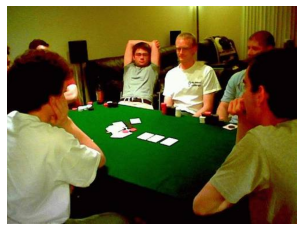

In [5]:
# 이미지 예시
IMG_PATH = "./flickr30k-images/36979.jpg"
# image_id = captions[25].split('.')[0]

# img = cv2.imread(IMG_PATH + image_id + ".jpg")
img = cv2.imread(IMG_PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

In [6]:
# 출처 : https://github.com/BryanPlummer/flickr30k_entities
import xml.etree.ElementTree as elemTree

def get_annotations(fn):
    """
    Parses the xml files in the Flickr30K Entities dataset
    input:
      fn - full file path to the annotations file to parse
    output:
      dictionary with the following fields:
          scene - list of identifiers which were annotated as
                  pertaining to the whole scene
          nobox - list of identifiers which were annotated as
                  not being visible in the image
          boxes - a dictionary where the fields are identifiers
                  and the values are its list of boxes in the 
                  [xmin ymin xmax ymax] format
    """
    tree = elemTree.parse(fn)
    root = tree.getroot()
    size_container = root.findall('size')[0]
    anno_info = {'boxes' : {}, 'scene' : [], 'nobox' : []}
    for size_element in size_container:
        anno_info[size_element.tag] = int(size_element.text)

    for object_container in root.findall('object'):
        for names in object_container.findall('name'):
            box_id = names.text
            box_container = object_container.findall('bndbox')
            if len(box_container) > 0:
                if box_id not in anno_info['boxes']:
                    anno_info['boxes'][box_id] = []
                xmin = int(box_container[0].findall('xmin')[0].text) - 1
                ymin = int(box_container[0].findall('ymin')[0].text) - 1
                xmax = int(box_container[0].findall('xmax')[0].text) - 1
                ymax = int(box_container[0].findall('ymax')[0].text) - 1
                anno_info['boxes'][box_id].append([xmin, ymin, xmax, ymax])
            else:
                nobndbox = int(object_container.findall('nobndbox')[0].text)
                if nobndbox > 0:
                    anno_info['nobox'].append(box_id)

                scene = int(object_container.findall('scene')[0].text)
                if scene > 0:
                    anno_info['scene'].append(box_id)

    return anno_info

def get_sentence_data(fn):
    """
    Parses a sentence file from the Flickr30K Entities dataset

    input:
      fn - full file path to the sentence file to parse
    
    output:
      a list of dictionaries for each sentence with the following fields:
          sentence - the original sentence
          phrases - a list of dictionaries for each phrase with the
                    following fields:
                      phrase - the text of the annotated phrase
                      first_word_index - the position of the first word of
                                         the phrase in the sentence
                      phrase_id - an identifier for this phrase
                      phrase_type - a list of the coarse categories this 
                                    phrase belongs to

    """
    with open(fn, 'r') as f:
        sentences = f.read().split('\n')

    annotations = []
    for sentence in sentences:
        if not sentence:
            continue

        first_word = []
        phrases = []
        phrase_id = []
        phrase_type = []
        words = []
        current_phrase = []
        add_to_phrase = False
        for token in sentence.split():
            if add_to_phrase:
                if token[-1] == ']':
                    add_to_phrase = False
                    token = token[:-1]
                    current_phrase.append(token)
                    phrases.append(' '.join(current_phrase))
                    current_phrase = []
                else:
                    current_phrase.append(token)

                words.append(token)
            else:
                if token[0] == '[':
                    add_to_phrase = True
                    first_word.append(len(words))
                    parts = token.split('/')
                    phrase_id.append(parts[1][3:])
                    phrase_type.append(parts[2:])
                else:
                    words.append(token)
                    
        sentence_data = {'sentence' : ' '.join(words), 'phrases' : []}
        for index, phrase, p_id, p_type in zip(first_word, phrases, phrase_id, phrase_type):
            sentence_data['phrases'].append({'first_word_index' : index,
                                             'phrase' : phrase,
                                             'phrase_id' : p_id,
                                             'phrase_type' : p_type})

        annotations.append(sentence_data)

    return annotations


In [7]:
anno_info = get_annotations('./flickr30k_ann/Annotations/36979.xml')
anno_info

{'boxes': {'137644': [[187, 49, 271, 169],
   [265, 39, 375, 198],
   [1, 69, 174, 371],
   [320, 73, 499, 372],
   [359, 39, 464, 204]],
  '137645': [[103, 159, 401, 335]],
  '137646': [[162, 190, 299, 244]]},
 'scene': [],
 'nobox': ['137647', '137648', '137650', '137651'],
 'width': 500,
 'height': 375,
 'depth': 3}

In [8]:
sent = get_sentence_data("./flickr30k_ann/Sentences/36979.txt")
sent

[{'sentence': 'A group of friends playing cards and trying to bluff each other into making a terrible mistake .',
  'phrases': [{'first_word_index': 0,
    'phrase': 'A group of friends',
    'phrase_id': '137644',
    'phrase_type': ['people']},
   {'first_word_index': 5,
    'phrase': 'cards',
    'phrase_id': '137645',
    'phrase_type': ['other']},
   {'first_word_index': 10,
    'phrase': 'each other',
    'phrase_id': '0',
    'phrase_type': ['notvisual']},
   {'first_word_index': 14,
    'phrase': 'a terrible mistake',
    'phrase_id': '137650',
    'phrase_type': ['other']}]},
 {'sentence': 'A group of college students gathers to play texas hold em poker .',
  'phrases': [{'first_word_index': 0,
    'phrase': 'A group of college students',
    'phrase_id': '137644',
    'phrase_type': ['people']},
   {'first_word_index': 8,
    'phrase': 'texas',
    'phrase_id': '137648',
    'phrase_type': ['other']},
   {'first_word_index': 10,
    'phrase': 'em',
    'phrase_id': '137651',


- captions

In [9]:
import os
Flickr_text_dir = "./flickr30k-images/annotation/30k_captions.txt"
Flickr_jpg_dir = "./flickr30k-images/"
jpgs = os.listdir(Flickr_jpg_dir)  # os.listdir(path) returns list containing names of entries in directory given by path.
print("Number of .jpg flies in Flicker8k Dataset: {}".format(len(jpgs)))

import pandas as pd
import numpy as np
file = open(Flickr_text_dir,'r', encoding="utf8") # Opening File
text = file.read() # Reading File
file.close() # Closing File
datatxt = []
for line in text.split('\n'): # Loop runs for No. of Images present
    col = line.split('\t') # Splits into 2 tuples on basis of '\t'
    if len(col) == 1:
        continue
    w = col[0].split("#") # Splits 1st tuple on basis of '#'
    datatxt.append(w + [col[1].lower()])
df_txt_flickr = pd.DataFrame(datatxt,columns=["filename","index","caption"])
uni_filenames = np.unique(df_txt_flickr.filename.values)  # uni_filenames stores unique file name e.g. '1000268201_693b08cb0e.jpg'
print("Total no. of Unique File Names: {}".format(len(uni_filenames)))

Number of .jpg flies in Flicker8k Dataset: 31787
Total no. of Unique File Names: 31783


In [10]:
df_txt_flickr

,filename,index,caption
0,1000092795.jpg,0,two young guys with shaggy hair look at their ...
1,1000092795.jpg,1,"two young , white males are outside near many ..."
2,1000092795.jpg,2,two men in green shirts are standing in a yard .
3,1000092795.jpg,3,a man in a blue shirt standing in a garden .
4,1000092795.jpg,4,two friends enjoy time spent together .
...,...,...,...
158910,998845445.jpg,0,a man in shorts and a hawaiian shirt leans ove...
158911,998845445.jpg,1,"a young man hanging over the side of a boat , ..."
158912,998845445.jpg,2,a man is leaning off of the side of a blue and...
158913,998845445.jpg,3,"a man riding a small boat in a harbor , with f..."


In [11]:
import statistics

def getbboxinfo(anno_info):
    size = []
    bbox = []
    index = []
    info = []
    max_size = 0
    max_index = 0
    for a in anno_info['boxes']:
        if len(anno_info['boxes'][a]) != 1:
            for b in anno_info['boxes'][a]:
                box_size = abs(b[0]-b[1])*abs(b[2]-b[3])
                bbox.append([b[0], b[1], b[2], b[3]])
                size.append(box_size)
                index.append(a)
                
        else:
            one_box = anno_info['boxes'][a][0]
            box_size = abs(one_box[0]-one_box[1])*abs(one_box[2]-one_box[3])
            bbox.append([one_box[0], one_box[1], one_box[2], one_box[3]])
            size.append(box_size)
            index.append(a)

        if box_size > max_size: 
            max_size = box_size
            max_index = index[size.index(max(size))]
            max_bbox = bbox[size.index(max(size))]
            midpoint = [(max_bbox[0] + max_bbox[1])/2,(max_bbox[2] + max_bbox[3])/2]
            info.append([max_index, max_size, midpoint, max_bbox])

    return info

In [12]:
def getphrase(sent_info, max_obj_id):
    phrase = []
    phrase_type = []

    # phrase id가 string 형태로 포함되어 있음
    for i in range(len(sent_info)):
        for a in sent_info[i]['phrases']:
            if a['phrase_id'] == str(max_obj_id):
                phrase.append(a['phrase'])
                phrase_type.append(a['phrase_type'][0])
    phrase_type = list(np.unique(phrase_type))
    return phrase, phrase_type

#### 예제

In [13]:
img = 36979
anno_path = './flickr30k_ann/Annotations/' + str(img) +'.xml'
sent_path = './flickr30k_ann/Sentences/' + str(img) +'.txt'

anno_info = get_annotations(anno_path)
sent = get_sentence_data(sent_path)

info = getbboxinfo(anno_info)

image_caption = {}
image_caption[img] = {}
image_caption[img]['img_id'] = info[0][0]
image_caption[img]['file_name'] = img 
image_caption[img]['width'] = anno_info['width']
image_caption[img]['height'] = anno_info['height']
image_caption[img]['objects_count'] = len(sum(anno_info['boxes'].values(),[]))
image_caption[img]['max_obj_id'] = info[0][0]

phrase, phrase_type = getphrase(sent, info[0][0])

image_caption[img]['max_obj_cat'] = phrase
image_caption[img]['max_obj_super_cat'] = phrase_type
# image_caption['max_obj_cat'] = ### 숫자로 표현
image_caption[img]['max_obj_area'] = info[0][1]
image_caption[img]['max_obj_midspoint'] = info[0][2]
image_caption[img]['max_obj_bbox'] = info[0][3]
# image_caption['max_obj_segment_points'] = flickr30k의 경우 segment point들은 포함되어 있지 x
image_caption[img]['max_obj_area_portion'] = info[0][1]/(anno_info['width']*anno_info['height'])
image_caption[img]['captions'] = [sent[i]['sentence'] for i in range(5)]

In [14]:
pwd

'/home/sunwookim/codes/data'

In [15]:
import json
image_caption = {}

for img in file_name:

    print(img)
    anno_path =  './flickr30k_ann/Annotations/' + str(img) +'.xml'
    sent_path = './flickr30k_ann/Sentences/' + str(img) +'.txt'

    anno_info = get_annotations(anno_path)
    sent = get_sentence_data(sent_path)
    info = getbboxinfo(anno_info)

    if len(info) == 0:
        break;
    else:
        image_cap = {}
        image_cap[img] = {}
        image_cap[img]['img_id'] = info[0][0]
        image_cap[img]['file_name'] = img 
        image_cap[img]['width'] = anno_info['width']
        image_cap[img]['height'] = anno_info['height']
        image_cap[img]['objects_count'] = len(sum(anno_info['boxes'].values(),[]))
        image_cap[img]['max_obj_id'] = info[0][0]

        phrase, phrase_type = getphrase(sent, info[0][0])

        image_cap[img]['max_obj_cat'] = phrase
        image_cap[img]['max_obj_super_cat'] = phrase_type
        # image_cap['max_obj_cat'] = ### 숫자로 표현
        image_cap[img]['max_obj_area'] = info[0][1]
        image_cap[img]['max_obj_midspoint'] = info[0][2]
        image_cap[img]['max_obj_bbox'] = info[0][3]
        # image_cap['max_obj_segment_points'] = flickr30k의 경우 segment point들은 포함되어 있지 x
        image_cap[img]['max_obj_area_portion'] = info[0][1]/(anno_info['width']*anno_info['height'])
        image_cap[img]['captions'] = [sent[i]['sentence'] for i in range(5)]    
    
    image_caption.update(image_cap)

170540666
3344175369
4823178827
500308355
3041645937
80835424
3243591844
4981472155
5403972062
4671516679
3984282687
242216901
3303787342
3264004517
4869280869
1010087179
17744613
201965684
46601243
4482796342
2624044128
354642192
2473955843
3019199755
2817414272
638855308
4539608494
4793562214
5419038647
7828338600
4945997009
3899294432
3373946160
3451984463
1119418776
4820525092
4516262474
2980445969
3610830444
4803925182
2841449931
3118425885
530888330
7148191955
2916179149
3899733725
164788783
50713403
4984199246
166774567
3355683198
1765164972
2254913901
257180093
2667943984
3241298741
2804904604
2500354186
178935935
1643915227
3126681108
2777101492
2213987357
6319369709
4946986337
2720190418
4161126086
77432938
1462461942
287212060
3030728199
2272750492
3432187474
3624076529
4527656043
7807617146
1527297882
2600386812
288038357
3352871762
3328337417
6651302933
7007309854
7421349720
2424398046
3027384992
2792195540
3787376866
4644618443
3215589470
4914906265
3612249030
1748132477


In [16]:
image_caption['170540666']

{'img_id': '19089',
 'file_name': '170540666',
 'width': 375,
 'height': 500,
 'objects_count': 19,
 'max_obj_id': '19089',
 'max_obj_cat': ['Two people', 'A couple'],
 'max_obj_super_cat': ['people'],
 'max_obj_area': 7830,
 'max_obj_midspoint': [79.0, 350.5],
 'max_obj_bbox': [64, 94, 220, 481],
 'max_obj_area_portion': 0.04176,
 'captions': ['Two people in dark jogging suits walk with a group of participants in the Race For The Cure .',
  'A man and a woman walk through the street during a parade .',
  'A couple walks with others for Race for the Cure .',
  'People are walking the marathon for a cause .',
  'Many people walk to fight breast cancer .']}

In [17]:
with open('flickr30k_entities.json', 'w') as f : 
	json.dump(image_caption, f, indent=4)